# mlbotの初心者向けチュートリアル(BitFlyer版)

richmanbtcさんのmlbotの初心者向けチュートリアルをBitFlyer向けに記載したものです。

## 必要なライブラリのインポート

以下のコードでは必要なライブラリをインポートしています。

In [1]:
import math

import ccxt
from crypto_data_fetcher.gmo import GmoFetcher
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib
import datetime,time,requests
from datetime import timedelta

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

## データを用意
BitFlyerのAPI(チャート用)を利用して1分足のOHLCVを取得します。

In [2]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'}

start_datetime = datetime.datetime.strptime("2021-12-25 00:00:00", "%Y-%m-%d %H:%M:%S")
end_datetime = datetime.datetime.strptime("2018-01-07 00:00:00", "%Y-%m-%d %H:%M:%S")
target_coin = "FX_BTC_JPY"


ohlc_list=[]
while start_datetime > end_datetime:
    unixtime = start_datetime.timestamp() * 1000
    response = requests.get( f"https://lightchart.bitflyer.com/api/ohlc?symbol={target_coin}&period=m&before={unixtime}", headers= headers).json()
    ohlc_list.extend(response)
    start_datetime -= timedelta(minutes=720)
    time.sleep(1)


df_1m = pd.DataFrame(ohlc_list,columns=['timestamp', 'op', 'hi', 'lo', 'cl', 'volume','volume_buy_sum','volume_sell_sum','volume_buy','volume_sell'])
df_1m["timestamp"] = pd.to_datetime(df_1m["timestamp"]/1000,unit='s', utc=True)
df_1m.set_index("timestamp",inplace=True)
df_1m.sort_index(inplace=True)
display(df_1m)

df_1m.to_pickle('df_bf_fx_ohlcv_1m.pkl')

,op,hi,lo,cl,volume,volume_buy_sum,volume_sell_sum,volume_buy,volume_sell
timestamp,,,,,,,,,
2017-12-31 12:01:00+00:00,1789201.0,1796499.0,1789201.0,1796045.0,51.048680,5651.456831,5296.531221,14.459341,36.589340
2017-12-31 12:02:00+00:00,1796045.0,1800000.0,1796000.0,1798992.0,83.028621,5723.218678,5398.086533,24.356414,58.672206
2017-12-31 12:03:00+00:00,1798992.0,1803479.0,1796001.0,1798988.0,47.985179,5823.559419,5653.007084,26.191251,21.793928
2017-12-31 12:04:00+00:00,1798988.0,1798989.0,1795926.0,1798224.0,25.099770,5864.039516,5773.064378,9.261953,15.837818
2017-12-31 12:05:00+00:00,1798224.0,1804980.0,1797794.0,1804980.0,46.756397,5923.189806,6011.056341,8.127900,38.628497
...,...,...,...,...,...,...,...,...,...
2021-12-24 11:56:00+00:00,6036442.0,6040295.0,6032209.0,6037141.0,6.320981,142.132339,294.936045,3.765134,2.555847
2021-12-24 11:57:00+00:00,6037040.0,6041572.0,6037040.0,6037614.0,2.242919,143.141336,291.242912,1.178000,1.064919
2021-12-24 11:58:00+00:00,6038054.0,6041000.0,6036183.0,6040231.0,2.725087,141.968879,295.253930,0.870000,1.855087


1分足のOHLCVを15分足に変換します。

In [49]:
df_1m = pd.read_pickle('df_bf_fx_ohlcv_1m.pkl')
rule = "15T"
df = pd.DataFrame()
df["op"] = df_1m["op"].resample(rule).first()
df["hi"] = df_1m["hi"].resample(rule).max()
df["lo"] = df_1m["lo"].resample(rule).min()
df["cl"] = df_1m["cl"].resample(rule).last()
df["volume"] = df_1m["volume"].resample(rule).sum()

display(df)
df.to_pickle('df_bf_fx_ohlcv.pkl')

,op,hi,lo,cl,volume
timestamp,,,,,
2017-12-31 12:00:00+00:00,1789201.0,1814131.0,1789201.0,1810002.0,626.843764
2017-12-31 12:15:00+00:00,1810002.0,1846340.0,1805537.0,1835996.0,606.898902
2017-12-31 12:30:00+00:00,1835996.0,1854456.0,1825300.0,1852357.0,878.611791
2017-12-31 12:45:00+00:00,1852357.0,1855385.0,1810502.0,1816001.0,881.816072
2017-12-31 13:00:00+00:00,1816001.0,1834128.0,1801891.0,1803342.0,494.191950
...,...,...,...,...,...
2021-12-24 11:00:00+00:00,6045344.0,6061483.0,6041000.0,6060852.0,25.866743
2021-12-24 11:15:00+00:00,6059078.0,6080744.0,6047563.0,6050673.0,78.644297
2021-12-24 11:30:00+00:00,6049181.0,6050671.0,6030100.0,6030100.0,50.062544


No handles with labels found to put in legend.


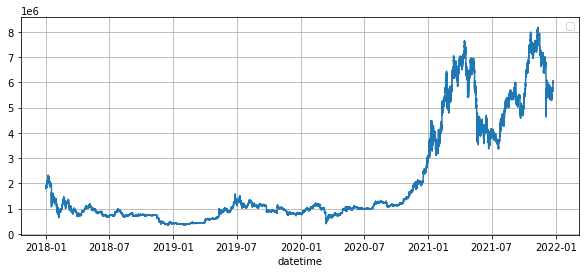

In [50]:
# プロット
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df['cl'])
ax.set_xlabel('datetime')
ax.grid(True)
ax.legend()
plt.show()

# #pip install "git+https://github.com/hudson-and-thames/mlfinlab.git"
# from mlfinlab.features.fracdiff import FractionalDifferentiation

# fdiff = FractionalDifferentiation()
# # d = 1.0
# d_10 = fdiff.frac_diff_ffd(df['cl'], 1)
# d_10.close.plot()

## maker手数料カラムを追加
0円とする。SFDの手数料の考慮は省略。  
https://bitflyer.com/ja-jp/commission

In [51]:
df = pd.read_pickle('df_bf_fx_ohlcv.pkl')
df['fee'] = 0.0
display(df)
df.to_pickle('df_bf_fx_ohlcv_with_fee.pkl')

,op,hi,lo,cl,volume,fee
timestamp,,,,,,
2017-12-31 12:00:00+00:00,1789201.0,1814131.0,1789201.0,1810002.0,626.843764,0.0
2017-12-31 12:15:00+00:00,1810002.0,1846340.0,1805537.0,1835996.0,606.898902,0.0
2017-12-31 12:30:00+00:00,1835996.0,1854456.0,1825300.0,1852357.0,878.611791,0.0
2017-12-31 12:45:00+00:00,1852357.0,1855385.0,1810502.0,1816001.0,881.816072,0.0
2017-12-31 13:00:00+00:00,1816001.0,1834128.0,1801891.0,1803342.0,494.191950,0.0
...,...,...,...,...,...,...
2021-12-24 11:00:00+00:00,6045344.0,6061483.0,6041000.0,6060852.0,25.866743,0.0
2021-12-24 11:15:00+00:00,6059078.0,6080744.0,6047563.0,6050673.0,78.644297,0.0
2021-12-24 11:30:00+00:00,6049181.0,6050671.0,6030100.0,6030100.0,50.062544,0.0


## 特徴量エンジニアリング

In [62]:
def calc_features(df):
    open = df['op']
    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    
    orig_columns = df.columns

    hilo = (df['hi'] + df['lo']) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)

    periods = [3,5,8,13,21,55,89]
    for period in periods:
        col = 'RETURN_{}'.format(period)
        df[col] = \
            df['cl'].pct_change(period)

        if period !=1:
            col = 'VOL_{}'.format(period)
            df[col] = \
                np.log(df['cl']).diff().rolling(period).std()
            
        col = 'MA_GAP_{}'.format(period)
        df[col] = \
            df['cl'] / (df['cl'].rolling(period).mean())
    
    df['hilo'] = df['hi'] - df['lo']
    df['PER_HILO'] = df['hilo'] / (hilo+1)
    df['opcl'] = df['op'] - df['cl']
    df['PER_OPCL'] = df['opcl'] / (hilo+1)

    # df['LOG_OPCL'] = df['opcl'].apply(np.log)

    return df

df = pd.read_pickle('df_bf_fx_ohlcv_with_fee.pkl')
df = df.dropna()
df = calc_features(df)

# df['opcl'].hist(alpha=0.3, label='買い')
# df['LOG_OPCL'].hist(alpha=0.3, label='売り')
# plt.title('エグジットまでの時間分布',fontname="Meiryo")
# plt.legend( prop={"family":"Meiryo"})
# plt.show()


df.to_pickle('df_bf_fx_features.pkl')

## 学習に使う特徴量の定義

In [63]:
features = sorted([
    #  'ADX',
#     'ADXR',
#     'APO',
#     'AROON_aroondown',
#     'AROON_aroonup',
#     'AROONOSC',
#     'CCI',
#     'DX',
#     'MACD_macd',
#     'MACD_macdsignal',
#     'MACD_macdhist',
#     'MFI',
# #     'MINUS_DI',
# #     'MINUS_DM',
    # 'MOM',
# #     'PLUS_DI',
# #     'PLUS_DM',
#     'RSI',
#     'STOCH_slowk',
#     'STOCH_slowd',
#     'STOCHF_fastk',
# #     'STOCHRSI_fastd',
#     'ULTOSC',
#     'WILLR',
# #     'ADOSC',
# #     'NATR',
#     'HT_DCPERIOD',
#     'HT_DCPHASE',
#     'HT_PHASOR_inphase',
#     'HT_PHASOR_quadrature',
#     'HT_TRENDMODE',
#     'BETA',
#     'LINEARREG',
#     'LINEARREG_ANGLE',
#     'LINEARREG_INTERCEPT',
#     'LINEARREG_SLOPE',
#     'STDDEV',
#     'BBANDS_upperband',
#     'BBANDS_middleband',
#     'BBANDS_lowerband',
#     'DEMA',
#     'EMA',
#     'HT_TRENDLINE',
#     'KAMA',
#     'MA',
#     'MIDPOINT',
#     'T3',
#     'TEMA',
#     'TRIMA',
#     'WMA',
    'MACD_macd',
    'RSI',
    'VOL_3',
    'RETURN_3',
    'MA_GAP_3',
    'VOL_5',
    'RETURN_5',
    'MA_GAP_5',
    'VOL_21',
    'RETURN_21',
    'MA_GAP_21',
    'VOL_55',
    'RETURN_55',
    'MA_GAP_55',
    'PER_OPCL',
    'PER_HILO',
])

print(features)

['MACD_macd', 'MA_GAP_21', 'MA_GAP_3', 'MA_GAP_5', 'MA_GAP_55', 'PER_HILO', 'PER_OPCL', 'RETURN_21', 'RETURN_3', 'RETURN_5', 'RETURN_55', 'RSI', 'VOL_21', 'VOL_3', 'VOL_5', 'VOL_55']


## 目的変数の計算

約定確率を可視化。時期によって約定確率が大きく変わると良くない。


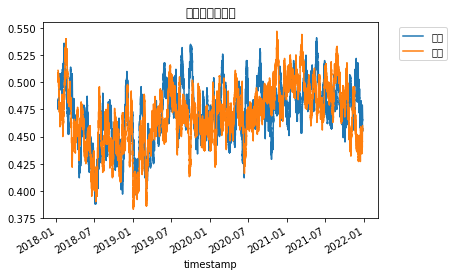

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


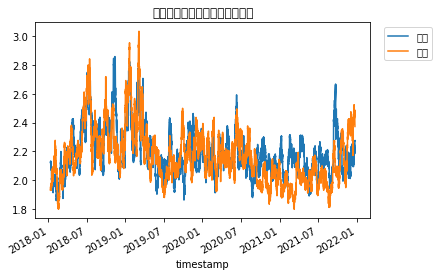

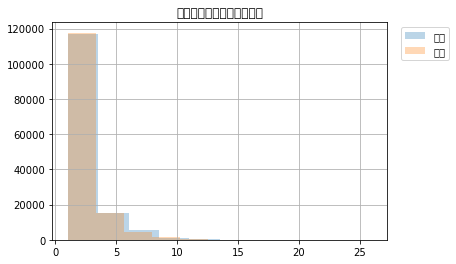

毎時刻、この執行方法でトレードした場合の累積リターン


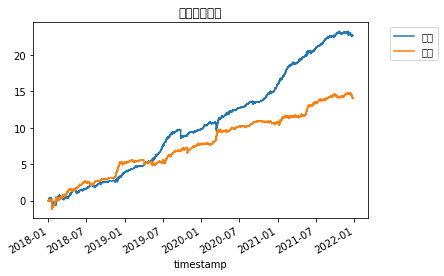

In [79]:
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

df = pd.read_pickle('df_bf_fx_features.pkl')

# 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
pips = 1

# ATRで指値距離を計算します
#limit_price_dist = df['ATR'] * 0.5
limit_price_dist = df['ATR'] * 0.4
limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

# 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
df['buy_price'] = df['cl'] - limit_price_dist
df['sell_price'] = df['cl'] + limit_price_dist

# Force Entry Priceの計算
df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['lo'].values,
    pips=pips,
)

# calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['hi'].values, # 売りのときは高値
    pips=pips,
)
df['sell_fep'] *= -1

horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
fee = df['fee'] # maker手数料

# 指値が約定したかどうか (0, 1)
df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['lo'].shift(-1) / pips).round()).astype('float64')
df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['hi'].shift(-1) / pips).round()).astype('float64')

# yを計算
df['y_buy'] = np.where(
    df['buy_executed'],
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
df['y_sell'] = np.where(
    df['sell_executed'],
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    0
)

# バックテストで利用する取引コストを計算
df['buy_cost'] = np.where(
    df['buy_executed'],
    df['buy_price'] / df['cl'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    df['sell_executed'],
    -(df['sell_price'] / df['cl'] - 1) + fee,
    0
)

print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
df['buy_executed'].rolling(1000).mean().plot(label='買い')
df['sell_executed'].rolling(1000).mean().plot(label='売り')
plt.title('約定確率の推移')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
df['buy_fet'].rolling(1000).mean().plot(label='買い')
df['sell_fet'].rolling(1000).mean().plot(label='売り')
plt.title('エグジットまでの平均時間推移')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

df['buy_fet'].hist(alpha=0.3, label='買い')
df['sell_fet'].hist(alpha=0.3, label='売り')
plt.title('エグジットまでの時間分布')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

print('毎時刻、この執行方法でトレードした場合の累積リターン')
df['y_buy'].cumsum().plot(label='買い')
df['y_sell'].cumsum().plot(label='売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('df_bf_fx_y.pkl')

## モデルの学習とOOS予測値計算

['MACD_macd', 'MA_GAP_21', 'MA_GAP_3', 'MA_GAP_5', 'MA_GAP_55', 'PER_HILO', 'PER_OPCL', 'RETURN_21', 'RETURN_3', 'RETURN_5', 'RETURN_55', 'RSI', 'VOL_21', 'VOL_3', 'VOL_5', 'VOL_55']
毎時刻、y_predがプラスのときだけトレードした場合の累積リターン


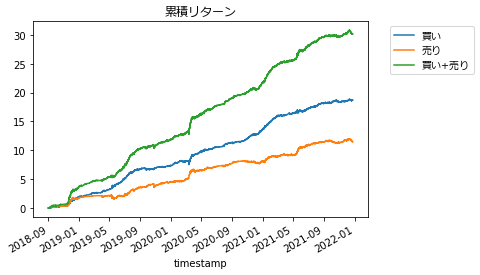

In [80]:
df = pd.read_pickle('df_bf_fx_y.pkl')
# df = df[df.index > pd.to_datetime('2020-01-01 00:00:00Z')]
df = df.dropna()

# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)

# アンサンブル (コメントアウトを外して性能を比較してみてください)
model = BaggingRegressor(model, random_state=1, n_jobs=1)

print(features)

# 本番用モデルの学習 (このチュートリアルでは使わない)
# 実稼働する用のモデルはデータ全体で学習させると良い
model.fit(df[features], df['y_buy'])
joblib.dump(model, './model/model_y_buy_bffx.xz', compress=True) 
model.fit(df[features], df['y_sell'])
joblib.dump(model, './model/model_y_sell_bffx.xz', compress=True)

# 通常のCV
#cv_indicies = list(KFold().split(df))
# ウォークフォワード法
cv_indicies = list(TimeSeriesSplit().split(df))

# OOS予測値を計算
def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred

df['y_pred_buy'] = my_cross_val_predict(model, df[features].values, df['y_buy'].values, cv=cv_indicies)
df['y_pred_sell'] = my_cross_val_predict(model, df[features].values, df['y_sell'].values, cv=cv_indicies)

# 予測値が無い(nan)行をドロップ
df = df.dropna()

print('毎時刻、y_predがプラスのときだけトレードした場合の累積リターン')
df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(label='買い')
df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(label='売り')
(df['y_buy'] * (df['y_pred_buy'] > 0) + df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum().plot(label='買い+売り')
plt.title('累積リターン',fontname="Meiryo")
plt.legend(bbox_to_anchor=(1.05, 1), prop={"family":"Meiryo"})
plt.show()

df.to_pickle('df_bf_fx_fit.pkl')

## バックテストと検定

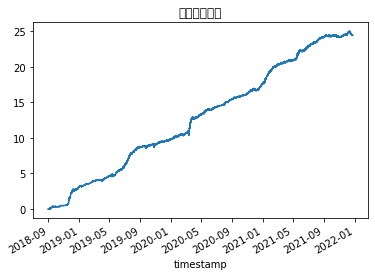

ポジション推移です。変動が細かすぎて青色一色になっていると思います。
ちゃんと全ての期間でトレードが発生しているので、正常です。


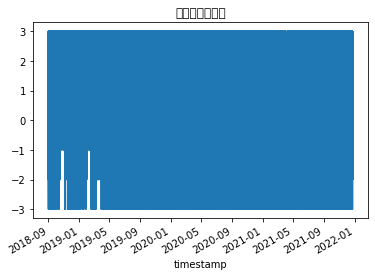

ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。


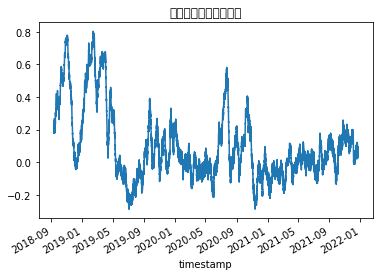

取引量(ポジション差分の絶対値)の累積です。
期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。


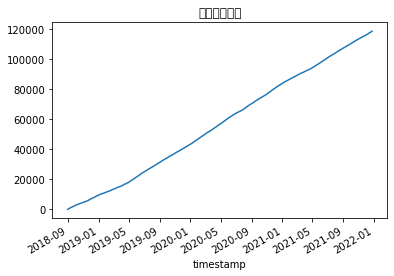

t検定
t値 11.411914277840108
p値 3.7840132373215556e-30
p平均法 n = 5
p平均 8.282246565165394e-05
エラー率 1.0148679858956511e-19


In [81]:
@numba.njit
def backtest(cl=None, hi=None, lo=None, pips=None,
              buy_entry=None, sell_entry=None,
              buy_cost=None, sell_cost=None
            ):
    n = cl.size
    y = cl.copy() * 0.0
    poss = cl.copy() * 0.0
    ret = 0.0
    pos = 0.0
    for i in range(n):
        prev_pos = pos
        
        # exit
        if buy_cost[i]:
            vol = np.maximum(0, -prev_pos)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_cost[i]:
            vol = np.maximum(0, prev_pos)
            ret -= sell_cost[i] * vol
            pos -= vol

        # entry
        if buy_entry[i] and buy_cost[i]:
            vol = np.minimum(1.0, 3 - prev_pos) * buy_entry[i]
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_entry[i] and sell_cost[i]:
            vol = np.minimum(1.0, prev_pos + 3) * sell_entry[i]
            ret -= sell_cost[i] * vol
            pos -= vol
        
        if i + 1 < n:
            ret += pos * (cl[i + 1] / cl[i] - 1)
            
        y[i] = ret
        poss[i] = pos
        
    return y, poss

df = pd.read_pickle('df_bf_fx_fit.pkl')

# バックテストで累積リターンと、ポジションを計算
df['cum_ret'], df['poss'] = backtest(
    cl=df['cl'].values,
    buy_entry=df['y_pred_buy'].values > 0,
    sell_entry=df['y_pred_sell'].values > 0,
    buy_cost=df['buy_cost'].values,
    sell_cost=df['sell_cost'].values,
)

df['cum_ret'].plot()
plt.title('累積リターン')
plt.show()

print('ポジション推移です。変動が細かすぎて青色一色になっていると思います。')
print('ちゃんと全ての期間でトレードが発生しているので、正常です。')
df['poss'].plot()
plt.title('ポジション推移')
plt.show()

print('ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。')
df['poss'].rolling(1000).mean().plot()
plt.title('ポジション平均の推移')
plt.show()

print('取引量(ポジション差分の絶対値)の累積です。')
print('期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。')
df['poss'].diff(1).abs().dropna().cumsum().plot()
plt.title('取引量の累積')
plt.show()

print('t検定')
x = df['cum_ret'].diff(1).dropna()
t, p = ttest_1samp(x, 0)
print('t値 {}'.format(t))
print('p値 {}'.format(p))

# p平均法 https://note.com/btcml/n/n0d9575882640
def calc_p_mean(x, n):
    ps = []
    for i in range(n):
        x2 = x[i * x.size // n:(i + 1) * x.size // n]
        if np.std(x2) == 0:
            ps.append(1)
        else:
            t, p = ttest_1samp(x2, 0)
            if t > 0:
                ps.append(p)
            else:
                ps.append(1)
    return np.mean(ps)

def calc_p_mean_type1_error_rate(p_mean, n):
    return (p_mean * n) ** n / math.factorial(n)

x = df['cum_ret'].diff(1).dropna()
p_mean_n = 5
p_mean = calc_p_mean(x, p_mean_n)
print('p平均法 n = {}'.format(p_mean_n))
print('p平均 {}'.format(p_mean))
print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))


## 実運用

In [82]:
# 最大ポジションサイズと月次利益の見積もり例
amount_per_day_jpy = 1000.0 * 10000 * 10000 # 1日の売買代金 1000億円
order_interval_min = 15.0 # 15分間隔で発注
monthly_return = 0.5 # 月次利益率 50%
my_order_ratio = 0.01 # 自分のボットの売買代金割合 1%

max_position_size = amount_per_day_jpy / (24 * 60) * order_interval_min * my_order_ratio
monthly_profit = max_position_size * monthly_return
print('最大ポジションサイズ {}円'.format(max_position_size))
print('月次利益 {}円'.format(monthly_profit))

最大ポジションサイズ 10416666.666666668円
月次利益 5208333.333333334円


##　売買判定 

BitFlyerが用意しているAPIからOHLCVを取得しモデルを利用して売買判定を出力します。
買い予想の数値(y_pred_buy)が0以上であれば買い、売り予想の数値(y_pred_sell)が0以上であれば売りと判断しています。
このためポジションの出力では買い予想の数値(y_pred_buy)のみが0以上の時に買い、売り予想の数値(y_pred_sell)のみが0以上の時に売りと判断しています。

In [83]:
#OHLCV取得
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'}
unixtime = datetime.datetime.now().timestamp() * 1000
target_coin = "FX_BTC_JPY"
ohlc_list=[]

#1000本以上の1分足を取得
while len(ohlc_list) < 1000:
    response = requests.get( f"https://lightchart.bitflyer.com/api/ohlc?symbol={target_coin}&period=m&before={unixtime}", headers= headers).json()
    ohlc_list.extend(response)
    current_after = datetime.datetime.fromtimestamp(response[-1][0]/1000)
    next_before = current_after - timedelta(minutes=1)
    unixtime = int(next_before.timestamp() * 1000)
    time.sleep(1)

df_1m = pd.DataFrame(ohlc_list,columns=['timestamp', 'op', 'hi', 'lo', 'cl', 'volume','volume_buy_sum','volume_sell_sum','volume_buy','volume_sell'])
df_1m["timestamp"] = pd.to_datetime(df_1m["timestamp"]/1000,unit='s', utc=True)
df_1m.set_index("timestamp",inplace=True)
df_1m.sort_index(inplace=True)

#15分足に変換
df = pd.DataFrame()
rule = "15T"
df["op"] = df_1m["op"].resample(rule).first()
df["hi"] = df_1m["hi"].resample(rule).max()
df["lo"] = df_1m["lo"].resample(rule).min()
df["cl"] = df_1m["cl"].resample(rule).last()
df["volume"] = df_1m["volume"].resample(rule).sum()

#特徴量の計算
df_features = calc_features(df)

#モデルの読み込み
model_y_buy = joblib.load('./model/model_y_buy_bffx.xz')
model_y_sell = joblib.load('./model/model_y_sell_bffx.xz')

#推論
df_features["predict_y_buy"] = model_y_buy.predict(df_features[features])
df_features["predict_y_sell"] = model_y_sell.predict(df_features[features])

#ポジションの判定

#買いポジションの判定
def calc_position_buy(x):
    buy = x["predict_y_buy"]
    if buy > 0:
        return "buy"
    else:
        return "none"
    
#売りポジションの判定
def calc_position_sell(x):
    buy = x["predict_y_sell"]
    if buy > 0:
        return "sell"
    else:
        return "none"

df_features["position_buy"] = df_features.apply(calc_position_buy,axis=1)
df_features["position_sell"] = df_features.apply(calc_position_sell,axis=1)

display(df_features)

position_buy = df_features["position_buy"].iloc[-1]
position_sell = df_features["position_sell"].iloc[-1]

if position_buy == "buy" and position_sell == "none":
    print("Buy Bitcoin")
elif position_sell == "sell" and position_buy == "none":
    print("Sell Bitcoin")
else:
    print("N/A")


,op,hi,lo,cl,volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,...,VOL_89,MA_GAP_89,hilo,PER_HILO,opcl,PER_OPCL,predict_y_buy,predict_y_sell,position_buy,position_sell
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-09 12:00:00+00:00,4969875.0,4972784.0,4943850.0,4950232.0,45.133169,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,28934.0,0.005835,19643.0,0.003962,-0.007259,-0.001880,none,none
2022-01-09 12:15:00+00:00,4950149.0,4954834.0,4942541.0,4951816.0,31.205986,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,12293.0,0.002484,-1667.0,-0.000337,-0.008377,-0.002206,none,none
2022-01-09 12:30:00+00:00,4952766.0,4962930.0,4946424.0,4957800.0,25.213028,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,16506.0,0.003331,-5034.0,-0.001016,-0.008079,-0.003173,none,none
2022-01-09 12:45:00+00:00,4957748.0,4963251.0,4951393.0,4952636.0,18.373238,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,11858.0,0.002392,5112.0,0.001031,-0.008383,-0.002653,none,none
2022-01-09 13:00:00+00:00,4952107.0,4959697.0,4944166.0,4956698.0,29.886937,7729.918810,1904.9,-3920.118810,NaN,NaN,...,NaN,NaN,15531.0,0.003136,-4591.0,-0.000927,-0.003333,-0.001468,none,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-10 12:15:00+00:00,4897291.0,4911085.0,4889000.0,4905493.0,85.144669,42897.387224,16037.1,-10823.187224,37274.842218,57401.349861,...,0.002829,0.985198,22085.0,0.004507,-8202.0,-0.001674,0.000109,0.000155,buy,sell
2022-01-10 12:30:00+00:00,4904574.0,4907854.0,4879107.0,4881812.0,81.737886,42182.333449,11932.7,-18316.933449,35691.182999,59083.875677,...,0.002873,0.980556,28747.0,0.005875,22762.0,0.004651,0.000262,0.000213,buy,sell
2022-01-10 12:45:00+00:00,4882130.0,4887310.0,4840053.0,4842133.0,202.605842,77686.236988,25276.5,-27133.236988,53209.831141,81758.270794,...,0.002974,0.972821,47257.0,0.009716,39997.0,0.008224,-0.000611,0.000600,none,sell


N/A


In [84]:
#初回だけ実行
#!pip install optuna

import optuna
optuna.logging.disable_default_handler()
import warnings
warnings.filterwarnings('ignore')


def calc_y(df,param):
    # 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
    pips = 1

    # ATRで指値距離を計算します
    limit_price_dist = df['ATR'] * param['atr']
    limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

    # 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
    df['buy_price'] = df['cl'] - limit_price_dist
    df['sell_price'] = df['cl'] + limit_price_dist

    #df['buy_price'] = df['cl'] + df['BBANDS_lowerband'] 
    #df['sell_price'] = df['cl'] + limit_price_dist 

    # Force Entry Priceの計算
    df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
        entry_price=df['buy_price'].values,
        lo=df['lo'].values,
        pips=pips,
    )

    # calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
    df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
        entry_price=-df['sell_price'].values,
        lo=-df['hi'].values, # 売りのときは高値
        pips=pips,
    )
    df['sell_fep'] *= -1

    horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
    fee = df['fee'] # maker手数料

    # 指値が約定したかどうか (0, 1)
    df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['lo'].shift(-1) / pips).round()).astype('float64')
    df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['hi'].shift(-1) / pips).round()).astype('float64')

    # yを計算
    df['y_buy'] = np.where(
        df['buy_executed'],
        df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
        0
    )
    df['y_sell'] = np.where(
        df['sell_executed'],
        -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
        0
    )

    # バックテストで利用する取引コストを計算
    df['buy_cost'] = np.where(
        df['buy_executed'],
        df['buy_price'] / df['cl'] - 1 + fee,
        0
    )
    df['sell_cost'] = np.where(
        df['sell_executed'],
        -(df['sell_price'] / df['cl'] - 1) + fee,
        0
    )
    return df

df_features = pd.read_pickle('df_bf_fx_features.pkl')
def objective(trial):
    atr = trial.suggest_uniform('atr', 0.0, 2.0)
    param = {"atr":atr}
    df = calc_y(df_features,param)
    score = df['y_buy'].cumsum().iloc[-1] + df['y_sell'].cumsum().iloc[-1]
    print("atr:{} score{}".format(atr,score))
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
# プログラムが試行錯誤した結果最も良いパラメータを表示
print("best param: {}".format(study.best_params))
# 最も良いパラメータで実行したときの結果（返り値）を表示
print("best score: {}".format(study.best_value))

atr:1.4458486152675762 score-7.538021749815207
atr:0.6861350727833913 score8.393725414430577
atr:0.1578080900386749 score-5.6712798501853054
atr:1.0913031976143388 score-5.434050454910432
atr:0.9802936721451379 score-1.4056925268025973
atr:0.7274101523067116 score4.648079052759157
atr:1.1186100221035455 score-4.119769057264516
atr:1.662037757239655 score-15.614765766848116
atr:1.9209525532580456 score-15.858354214577597
atr:0.11005540367673894 score-27.019733903813076
atr:0.5423450066355797 score28.453073747287426
atr:0.4937024227748946 score32.49277624874174
atr:0.4494331668105077 score35.92596739460535
atr:0.4987858857159395 score32.115109721528775
atr:0.3323402771864742 score34.76050924373466
atr:0.26347738242629254 score28.834910568525146
atr:0.03571353631275376 score-47.558383217876624
atr:0.8741393177528222 score4.7205747992211355
atr:0.36440933904455564 score36.76118718180959
atr:0.35491079538211534 score37.24714008804728
atr:0.7780413959486749 score6.444888445912833
atr:0.33221